# Lab 2

This lab is for practicing Python’s *generators* and the design of *streaming* algorithms in general. We’re going to use two Citibike's data sets: **citibike.csv** and **citibike_docking_events.csv**. Both are available on NYU Classes *Datasets* section.

## Task 1

Plotting the number of trips taken by hour of the day in '''citibike.csv'''. In this task, we would write a generator to convert each line of an input citibike CSV into a stream of “hour of the day” values.

In [1]:
import csv
import datetime
import dateutil
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_color_codes("muted")

%matplotlib inline

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
## This is how we usually read data from a CSV file.
## In this example, we extract the day of the week and
## the hour of the day from the "starttime" field. We
## print out these information for the line of the file.
## with open as f 这种格式是generator，只读取一次内容

with open('citibike.csv', 'r') as fi:
    reader = csv.DictReader(fi)
    for row in reader:
        starttime = dateutil.parser.parse(row['starttime'])
        print(row['starttime'])
        print(starttime.weekday(), starttime.hour)
        break

2015-02-01 00:00:00+00
6 0


In [3]:
## If we want to create a generator to iterate through
## through all the "hour of the day" in the files, we
## can create a wrapper function around our approach
## above. Note the use of "yield".

def citibike2hod(filename):
    with open(filename, 'r') as fi:
        reader = csv.DictReader(fi)
        for row in reader:
            starttime = dateutil.parser.parse(row['starttime'])
            yield(starttime.hour)
            
## 如果是generator，最后用yield，而且不像return那样是会中断的、只返回一次的

In [4]:
## We can then use a similar method to task 1 to compute
## and plot the histogram of the bike ride per hour.
import time

start = time.clock()
count = {}
for hod in citibike2hod('citibike.csv'):
    count[hod] = count.get(hod, 0)+1
print(time.clock() - start)

5.738794


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


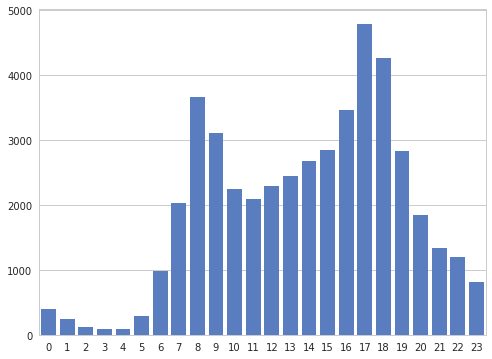

In [5]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=list(count.keys()), y=list(count.values()), color="b", ci=None)

## Task 2

Our task is to write a generator to extract the first ride of the day from a Citibike data stream. The data stream is sorted based on starting times. The first ride of the day is interpreted as the ride with the earliest starting time of a day.

We are given a template with the sample generator **firstRide**. The generator currently takes in **csv.DictReader** generator and output its first element. We need to adjust this generator to output the first ride of the day for the entire stream as specified above. The output of the generator must be in the same format as csv.DictReader. We can think of this generator as a filter only passing certain records through.

In [6]:
### NOTE: We need to change the body of the generator firstRide
### in order to output trip record that appeared first in each day
### using the same dict format as csv.DictReader.

def firstRide(reader):  # 因为出行记录是按照时间降序升序的
    lastDay = None
    for rider in reader:
        day = datetime.datetime.strptime(rider['starttime'], '%Y-%m-%d %H:%M:%S+%f')
        if lastDay != day.date():
            lastDay = day.date()
            yield rider

### NOTE: We SHOULD NOT modify the code below. If we
### write our firstRide generator above correctly, the
### code below will output the correct information

with open('citibike.csv', 'r') as fi:
    reader = csv.DictReader(fi)
    for row in firstRide(reader):
        # print(','.join(map(row.get, reader.fieldnames)))
        print(row["starttime"])

2015-02-01 00:00:00+00
2015-02-02 00:02:00+00
2015-02-03 00:00:00+00
2015-02-04 00:00:00+00
2015-02-05 00:00:00+00
2015-02-06 00:01:00+00
2015-02-07 00:00:00+00


## Task 3

Our task is to **compute the maximum number of active "citibikers"** that were using the Citibike service at any point in time. This the same as computing the maximum number of citibikes that were checked out at a particular time. The input data set is **citibike_docking_events.csv**, which logged all docking and undocking events at all Citibike stations. The description of the fields in this file is as follows:

|Column name|Description|
|--|--|
|time |The timestamp of the event. All events are sorted increasingly by their timestamps. |
|bikeid |The unique ID of the bike involved in this event. |
|station_id |The station ID, where the event happened. |
|event |A string of either *"dock"* or *"undock"* for describing the drop-off or pick-up event, respectively. |

For example, let's assume that on *Feb-01-2015*, there was a user that picked a bike at the station ID *521* at midnight and dropped it at the station ID *423* at 14 minutes past midnight. If the bike that this customer used has the ID of *17131*, then we should see two events being logged in this data set as:

<pre>
...
2015-02-01 00:00:00+00,17131,521,undock
...
2015-02-01 00:14:00+00,17131,423,dock
...
</pre>

We are given the above data set in a streaming fashion (reading in row by row), and must design a streaming algorithm that uses the least possible additional memory to compute the maximum number of active users of the Citibike service. Please modify the code snippet below to complete this task. The code should only output a single number, which is the number of active users. It is allowable to add additional initialization codes outside of the for loop as needed.

In [7]:
# 前提是按时间顺序排好序了
# 在每个时间点，加上解锁的，删去上锁的

def csvRows(filename):
    with open(filename, 'r') as fi:
        reader = csv.DictReader(fi)
        for row in reader:
            yield row

activeUsers = 0
maxActiveUsers, maxTime = 0, None
for row in csvRows('citibike_docking_events.csv'):
    if row['event'] == 'undock':
        activeUsers += 1
        if activeUsers > maxActiveUsers:
            maxActiveUsers, maxTime = activeUsers, row['time']
    else:
        activeUsers -= 1
    
print(maxActiveUsers)
print(maxTime)

250
2015-02-05 08:55:00+00


## Task 4

The objective of this task is identical to Task 3's but we are asked to use the **cibibike.csv** data set instead of the docking events. The main difference (and challenge) is that both pick-up and drop-off event for each trip is now presented as a single record, thus, the drop-off events are not sorted by their timestamps. We are again asked to do this in a streaming fashion that needs to minimize the amount of memory usage. Please modify the code below accordingly, and also with a brief explaination of the solution.

In [9]:
# 还没换车的人就是正在骑车的人
# 前提是按照时间排序，所以后面的时间一定比前面的大

def csvRows(filename):
    with open(filename, 'r') as fi:
        reader = csv.DictReader(fi)
        for row in reader:
            yield row

notYetReturn = []
maxActiveUsers,maxTime = 0,None
for row in csvRows('citibike.csv'):
    starttime = row['starttime']
    stoptime  = row['stoptime']
    notYetReturn = filter(lambda x: x > starttime, notYetReturn)
    notYetReturn = list(notYetReturn) + [stoptime]
    if len(notYetReturn) > maxActiveUsers:
        maxActiveUsers,maxTime = len(notYetReturn),starttime

print(maxActiveUsers)
print(maxTime)

250
2015-02-05 08:55:00+00
